In [1]:
import rclpy
import cv2
from sensor_msgs.msg import Image, PointCloud2
from matplotlib import pyplot as plt
import pymoveit2 
from rclpy.callback_groups import ReentrantCallbackGroup
from threading import Thread
from pymoveit2 import MoveIt2, GripperInterface
%matplotlib widget
rclpy.init()

In [2]:
node = rclpy.create_node("jupyter")
msg = None
depth = None
points = None

def depth_listener_callback(data):
    global depth
    depth = data

def points_listener_callback(data):
    global points
    points = data

def listener_callback(data):
    global msg
    msg = data

subs = [node.create_subscription(
            Image,
            '/realsense/'+n,
            cb,
            10) for (n, cb) in [("image", listener_callback),
                                ("depth_image", depth_listener_callback),
                                ]]

node.create_subscription(
            PointCloud2,
            '/realsense/points',
            points_listener_callback,
            10)

callback_group = ReentrantCallbackGroup()
moveit2 = MoveIt2(node=node, 
                  joint_names=['ur5_shoulder_pan_joint', 'ur5_shoulder_lift_joint',
                               'ur5_elbow_joint','ur5_wrist_1_joint',
                               'ur5_wrist_2_joint','ur5_wrist_3_joint'],
                  base_link_name='ur5_base_link',
                  end_effector_name='gripper',
                  group_name='arm',
                  callback_group=callback_group
                 )

  # Create gripper interface
gripper_interface = GripperInterface(
        node=node,
        gripper_joint_names=['finger_joint'],
        open_gripper_joint_positions=[0.0],
        closed_gripper_joint_positions=[0.07],
        gripper_group_name='gripper',
        callback_group=callback_group,
        gripper_command_action_name="gripper_controller/follow_joint_trajectory",
    )

# Spin the node in background thread(s) and wait a bit for initialization
executor = rclpy.executors.MultiThreadedExecutor(4)
executor.add_node(node)
executor_thread = Thread(target=executor.spin, daemon=True, args=())
executor_thread.start() # Using threads, our node will keep spinning while we code 

In [3]:
MoveIt2?

Init signature:
MoveIt2(
    node: rclpy.node.Node,
    joint_names: List[str],
    base_link_name: str,
    end_effector_name: str,
    group_name: str = 'arm',
    execute_via_moveit: bool = False,
    ignore_new_calls_while_executing: bool = False,
    callback_group: Optional[rclpy.callback_groups.CallbackGroup] = None,
    follow_joint_trajectory_action_name: str = 'DEPRECATED',
    use_move_group_action: bool = False,
)
Docstring:     
Python interface for MoveIt 2 that enables planning and execution of trajectories.
For execution, this interface requires that robot utilises JointTrajectoryController.
Init docstring:
Construct an instance of `MoveIt2` interface.
  - `node` - ROS 2 node that this interface is attached to
  - `joint_names` - List of joint names of the robot (can be extracted from URDF)
  - `base_link_name` - Name of the robot base link
  - `end_effector_name` - Name of the robot end effector
  - `group_name` - Name of the planning group for robot arm
  - [DEPRECATE

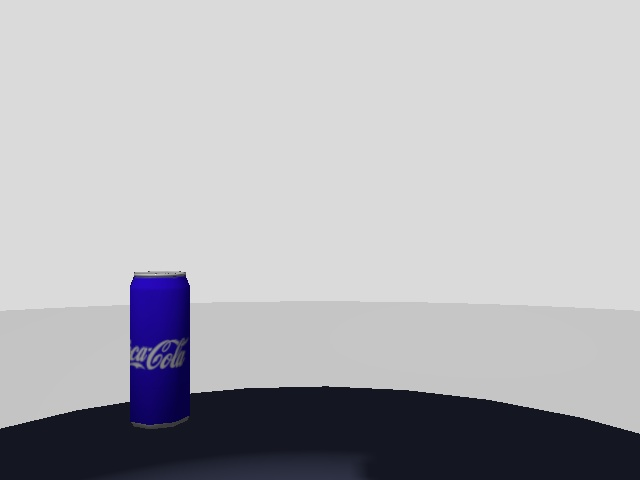

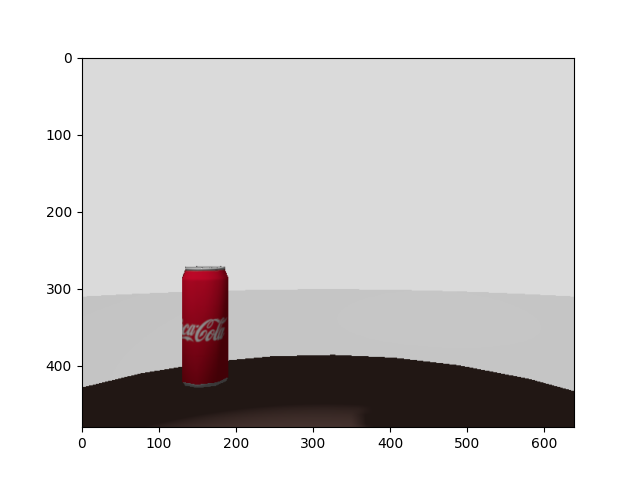

In [3]:
import cv2
import numpy as np
from sensor_msgs.msg import Image

# Assuming msg contains the image data
height = msg.height
width = msg.width
channels = msg.step // width
img = np.frombuffer(msg.data, dtype=np.uint8).reshape(height, width, channels)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


from IPython.display import display, Image as IPImage
from PIL import Image as PILImage
import io

# Convert OpenCV image to PIL image
_, buffer = cv2.imencode('.jpg', img)
io_buf = io.BytesIO(buffer)
pil_image = PILImage.open(io_buf)

# Display the image
display(pil_image)
plt.imshow(img)

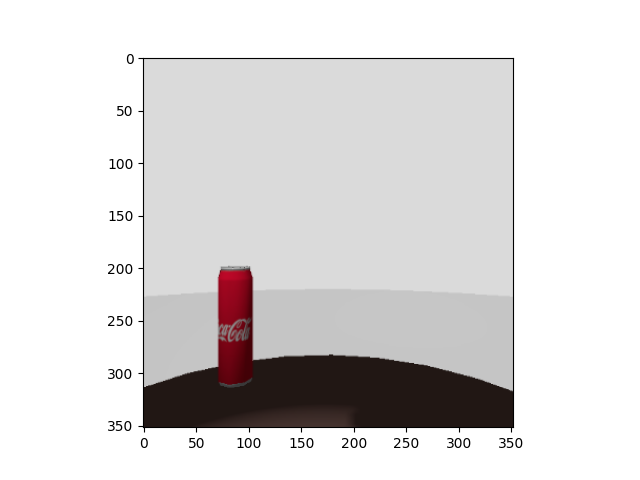

In [4]:
target_size = (352, 352)

res_img = cv2.resize(img, (352,352))

plt.imshow(res_img)
plt.show()

/workspace/myenv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


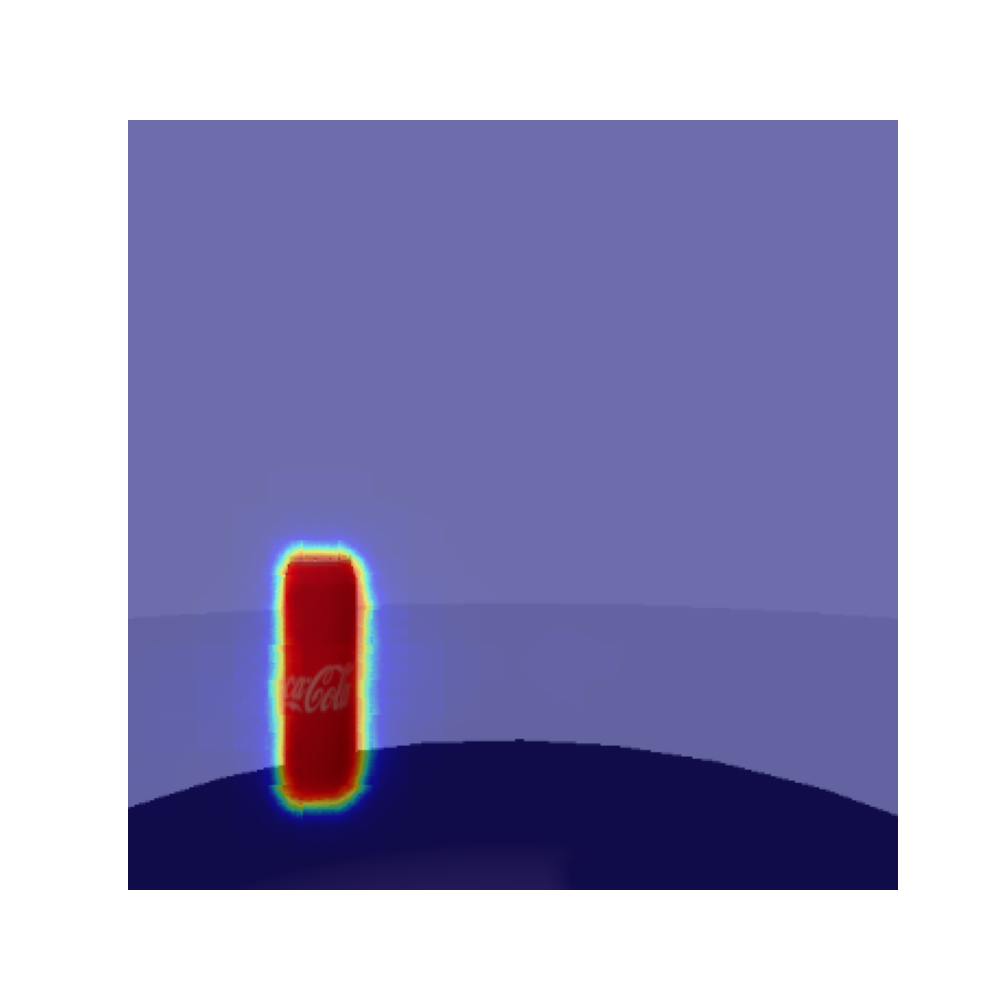

In [5]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

inputs = processor(text="a can of soda", images=res_img, return_tensors="pt")

outputs = model(**inputs)
mask = outputs.logits.sigmoid().detach().cpu().numpy()[0,:,:]

#depth_image = np.frombuffer(depth.data, dtype=np.float32).reshape(msg.height, msg.width)


plt.figure(figsize=(10, 10))
plt.imshow(res_img)
plt.imshow(mask, alpha=0.5, cmap="jet")
#plt.imshow(depth_image[:352,:352], alpha=0.5)
plt.axis("off")
plt.show()

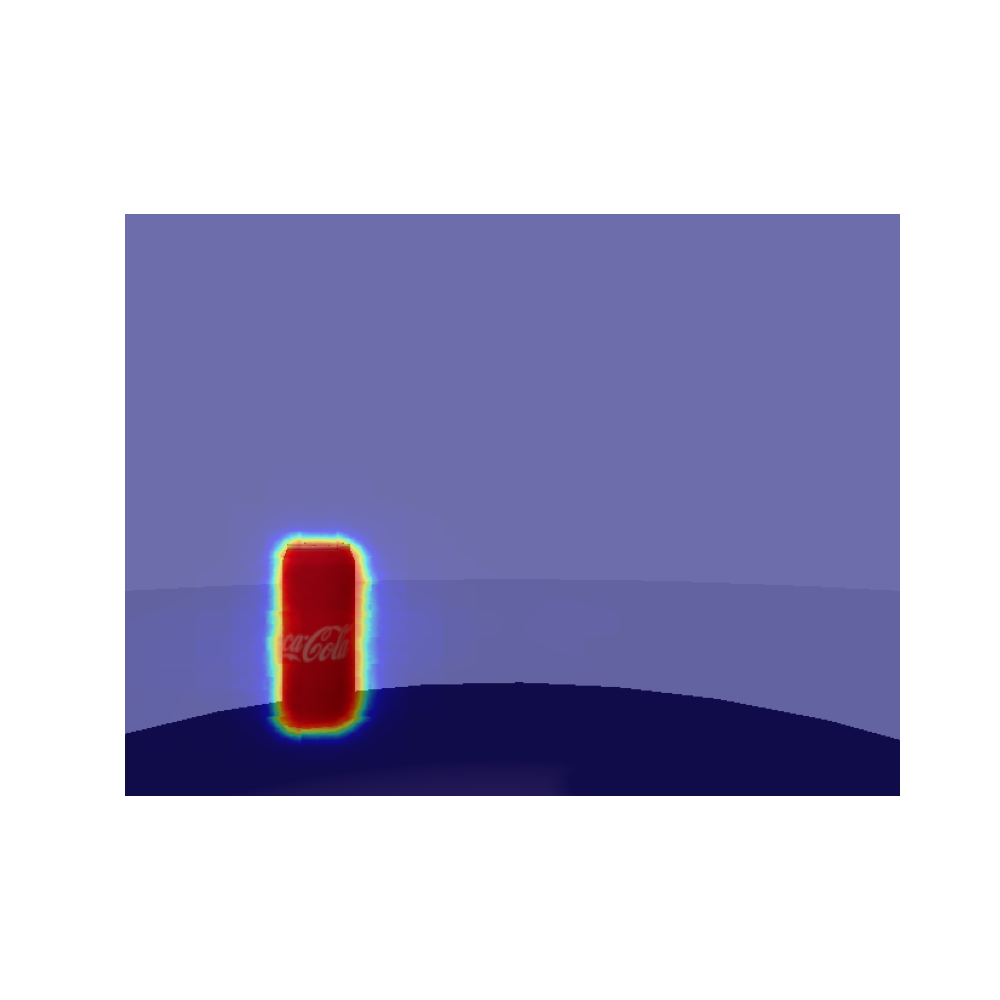

In [6]:
full_mask = cv2.resize(mask, (640,480))
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.imshow(full_mask, alpha=0.5, cmap="jet")
#plt.imshow(depth_image[:352,:352], alpha=0.5)
plt.axis("off")
plt.show()

In [7]:
mask.shape
img.shape

(480, 640, 3)

In [8]:
np.sum(mask > 0.9)

2917

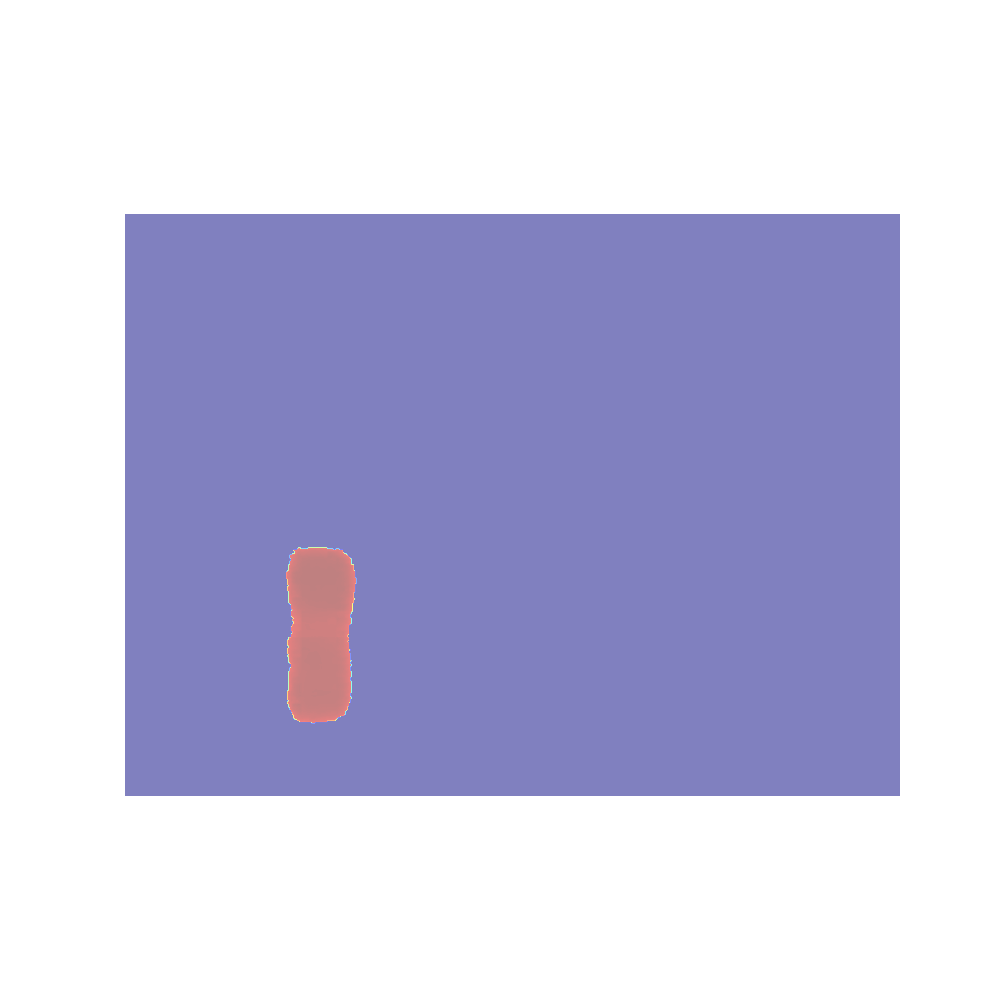

In [26]:
filtered_mask = full_mask.copy()
filtered_mask[full_mask < 0.9] =0

plt.figure(figsize=(10, 10))
#plt.imshow(img)
plt.imshow(filtered_mask, alpha=0.5, cmap="jet")
plt.axis("off")
plt.show()

In [27]:
depth_image = np.frombuffer(depth.data, dtype=np.float32).reshape(msg.height, msg.width)

def depth_to_point_cloud(depth_image, fx, fy, cx, cy):
    height, width = depth_image.shape
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    xx, yy = np.meshgrid(x, y)
    z = depth_image

    x = (xx - cx) * z / fx
    y = (yy - cy) * z / fy

    points = np.stack((x, y, z), axis=-1) #.reshape(-1, 3)
    return points

depth_points = depth_to_point_cloud(depth_image, fx=554.254, fy=554.25, cx=320.0, cy=240.0)


/tmp/ipykernel_8682/1882437878.py:10: RuntimeWarning: invalid value encountered in multiply
  x = (xx - cx) * z / fx
/tmp/ipykernel_8682/1882437878.py:11: RuntimeWarning: invalid value encountered in multiply
  y = (yy - cy) * z / fy


In [28]:
# Remove any infinite points from the filtered mask. 
filtered_mask[np.isfinite(depth_points).all(axis=2)==False] = 0

In [29]:
cylinder_points = depth_points[filtered_mask > 0.9]

finite_depth_points = cylinder_points

PyntCloud
7214 points with 0 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: -0.150154990052966, 0.0993782228638601, 0.5224887916742351
Other attributes:

PyntCloud
7212 points with 0 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: -0.1498867987160286, 0.09925444936416311, 0.5213127210777598
Other attributes:

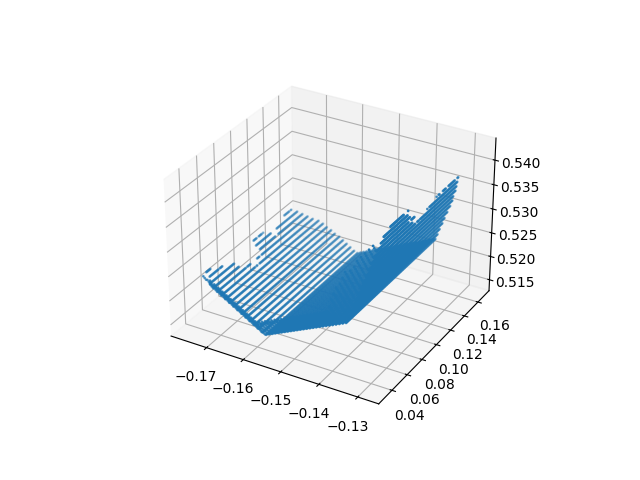

In [30]:
import pyntcloud
import pandas as pd


cloud = pyntcloud.PyntCloud(pd.DataFrame(finite_depth_points, columns=["x","y","z"]))
display(cloud)
k = 20  # Number of nearest neighbors to use
std_ratio = 1.0  # Standard deviation multiplier threshold
kdtree = cloud.add_structure("kdtree")
filt = cloud.get_filter("ROR",k=400, r=0.2, kdtree_id=kdtree)
#filt = cloud.get_filter("SOR",k=10, z_max=0.40, kdtree_id=kdtree)
cloud.apply_filter(filt)
display(cloud)


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
points_np = cloud.points.values

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], s=1)
plt.show()

In [31]:
from py_cylinder_fitting import BestFitCylinder
from skspatial.objects import Points

# Assuming extracted_points is a list of 3D points
points = Points(cloud.points.values)
best_fit_cylinder = BestFitCylinder(points)

# Get the cylinder parameters
cylinder_center = best_fit_cylinder.point
cylinder_axis = best_fit_cylinder.vector
cylinder_radius = best_fit_cylinder.radius

print("Cylinder Center:", cylinder_center)
print("Cylinder Axis:", cylinder_axis)
print("Cylinder Radius:", cylinder_radius)

cylinder_height = (cylinder_axis[0]**2 + cylinder_axis[1]**2 + cylinder_axis[2]**2) ** 0.5

print("Cylinder height: ", cylinder_height)

Cylinder Center: [-0.15699853  0.16712559  0.54200132]
Cylinder Axis: [ 1.30883971e-04 -1.35414462e-01  1.08875042e-03]
Cylinder Radius: 0.026407863469909417
Cylinder height:  0.13541890175872157


In [32]:
from geometry_msgs.msg import Pose

In [71]:
cylinder_height = (cylinder_axis[0]**2 + cylinder_axis[1]**2 + cylinder_axis[2]**2) ** 0.5

# Define the pose of the cylinder
cylinder_pose = Pose()
cylinder_pose.position.x = cylinder_center[2]
cylinder_pose.position.y = -cylinder_center[0]
cylinder_pose.position.z = -cylinder_center[1]+cylinder_height/2
cylinder_pose.orientation.w = 1.0  # Assuming no rotation


In [34]:
moveit2.add_collision_cylinder('soda', height=cylinder_height, radius=cylinder_radius, pose=cylinder_pose, frame_id="realsense_link")

In [35]:
moveit2.planner_id = 'geometric::RRTConnect'

In [72]:
import copy
approach = copy.copy(cylinder_pose)

In [73]:
approach

geometry_msgs.msg.Pose(position=geometry_msgs.msg.Point(x=0.5420013227466117, y=0.1569985292121295, z=-0.09941613478516961), orientation=geometry_msgs.msg.Quaternion(x=0.0, y=0.0, z=0.0, w=1.0))

In [76]:
approach.position.z+=0.4 # Alittle above
approach.position.x-=0.03 # Centering the approach in the gripper

In [77]:
def euler_to_quaternion(yaw, pitch, roll):

        qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
        qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
        qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
        qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)

        return [qx, qy, qz, qw]

euler_to_quaternion(0,np.pi,0)

[0.0, 1.0, 0.0, 6.123233995736766e-17]

In [78]:
approach.orientation.x=0.
approach.orientation.y=1.
approach.orientation.z=0.
approach.orientation.w=0.



In [81]:
approach

In [82]:
moveit2.move_to_pose(pose=approach, target_link="ur5_tool0", frame_id="realsense_link")

[WARN] [1727163236.571132904] [jupyter]: Action 'execute_trajectory' was unsuccessful: 6.


In [83]:
res = moveit2.allow_collisions('soda', allow=True)

In [84]:
approach.position.z -= 0.45

In [85]:
gripper_interface.open()

In [86]:
moveit2.move_to_pose(pose=approach, target_link="ur5_tool0", frame_id="realsense_link")

In [87]:
gripper_interface.close()

In [ ]:
moveit2.end